In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from pathlib import Path

# repository root: prefer file-based parent when available, else two levels up
try:
    ROOT = Path(__file__).resolve().parents[1]
except NameError:
    ROOT = Path().resolve().parents[1]


In [ ]:
# load splits
splits_dir = Path(ROOT) / "src" / "ryan" / "encoded_outputs"

X_train = pd.read_csv(splits_dir / "x_train.csv")
X_val   = pd.read_csv(splits_dir / "x_val.csv")
X_test  = pd.read_csv(splits_dir / "x_test.csv")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

y_train = pd.read_csv(splits_dir / "y_train.csv").squeeze()
y_val   = pd.read_csv(splits_dir / "y_val.csv").squeeze()
y_test  = pd.read_csv(splits_dir / "y_test.csv").squeeze()


# Drop match_id if still present accidentally
for df in [X_train, X_val, X_test]:
    if "match_id" in df.columns:
        df.drop(columns=["match_id"], inplace=True)

In [3]:
# convert to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_val_t   = torch.tensor(X_val.values, dtype=torch.float32)
X_test_t  = torch.tensor(X_test.values, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# create data loaders
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2048)
test_loader  = DataLoader(test_ds, batch_size=2048)

In [4]:
# create logistic regression model
input_dim = X_train.shape[1]

class LogisticRegression(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

model = LogisticRegression(input_dim)

In [ ]:
# handle side win imbalance
positive_weight = (len(y_train) - y_train.sum()) / y_train.sum()
positive_weight = float(positive_weight)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(positive_weight))

# optimizer w l2 regularization
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

In [6]:
# training loop
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    probs = []
    labels = []
    
    with torch.no_grad():
        for x, y in loader:
            p = model(x).squeeze()
            pred = (p >= 0.5).float()
            correct += (pred == y).sum().item()
            total += y.size(0)
            probs.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
    
    return correct / total, np.array(probs), np.array(labels)

epochs = 20
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        
        # weighted BCE loss
        weights = torch.where(yb == 1, positive_weight, 1.0)
        loss = nn.BCELoss(weight=weights)(preds, yb)
        
        loss.backward()
        optimizer.step()

    # validation accuracy
    val_acc, _, _ = evaluate(val_loader)
    print(f"Epoch {epoch+1}/{epochs} — Val Acc: {val_acc:.4f}")

Epoch 1/20 — Val Acc: 0.5596
Epoch 2/20 — Val Acc: 0.5629
Epoch 3/20 — Val Acc: 0.5643
Epoch 4/20 — Val Acc: 0.5660
Epoch 5/20 — Val Acc: 0.5713
Epoch 6/20 — Val Acc: 0.5719
Epoch 7/20 — Val Acc: 0.5702
Epoch 8/20 — Val Acc: 0.5733
Epoch 9/20 — Val Acc: 0.5769
Epoch 10/20 — Val Acc: 0.5764
Epoch 11/20 — Val Acc: 0.5757
Epoch 12/20 — Val Acc: 0.5761
Epoch 13/20 — Val Acc: 0.5771
Epoch 14/20 — Val Acc: 0.5779
Epoch 15/20 — Val Acc: 0.5783
Epoch 16/20 — Val Acc: 0.5750
Epoch 17/20 — Val Acc: 0.5779
Epoch 18/20 — Val Acc: 0.5757
Epoch 19/20 — Val Acc: 0.5773
Epoch 20/20 — Val Acc: 0.5754


Accuracy:  0.5728
Precision: 0.6872
Recall:    0.4588
F1 Score:  0.5502


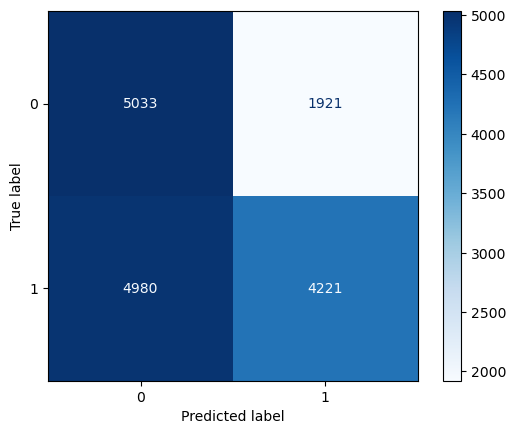

In [9]:
#eval 
test_preds = (test_probs >= 0.5).astype(int)

accuracy  = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall    = recall_score(test_labels, test_preds)
f1        = f1_score(test_labels, test_preds)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")
plt.show()